In [1]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np

In [2]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [17]:
nlabels

6

In [4]:
from GraphDataset import GraphDataset
#file_names = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
file_names = ['/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root']

graph_dataset = GraphDataset('gdata_train', features, labels, spectators, n_events=1000, n_events_merge=1, 
                             file_names=file_names)
#file_names_test = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']
file_names_test = ['/teams/DSC180A_FA20_A00/b06particlephysics/test/ntuple_merged_0.root']
test_dataset = GraphDataset('gdata_test', features, labels, spectators, n_events=2000, n_events_merge=1, 
                             file_names=file_names_test)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        self.edge_mlp = Seq(Lin(48*2, 128), 
                            BatchNorm1d(128),
                            ReLU(),
                            Lin(128, 128))

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)

class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp_1 = Seq(Lin(48+128, 128), 
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 128))
        self.node_mlp_2 = Seq(Lin(48+128, 128), 
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 128))

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

    
class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()
        self.global_mlp = Seq(Lin(128, 128),                               
                              BatchNorm1d(128),
                              ReLU(), 
                              Lin(128, 6))

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), GlobalBlock())
        self.bn = BatchNorm1d(48)
        
    def forward(self, x, edge_index, batch):
        
        x = self.bn(x)
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u
    
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [19]:
@torch.no_grad()
def test(model,loader,total,batch_size,leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        print(data)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size,leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [20]:
data.y

tensor([[1, 0]])

In [21]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate
test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

In [26]:
full_length-valid_num

74

In [22]:
import os.path as osp

n_epochs = 2
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size,leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size,leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

Batch(batch=[550], edge_index=[2, 18352], u=[18, 2], x=[550, 48], y=[18, 2])
Epoch: 00, Training Loss:   0.4884
           Validation Loss: 0.7012
New best model saved to: interactionnetwork_best.pth


Batch(batch=[550], edge_index=[2, 18352], u=[18, 2], x=[550, 48], y=[18, 2])

Epoch: 01, Training Loss:   0.4736
           Validation Loss: 0.6792
New best model saved to: interactionnetwork_best.pth



In [23]:
model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

In [19]:
data.y.cpu().numpy()

array([[1, 0]])

In [10]:
y_test.shape

(1889, 2)

In [11]:
y_predict.shape

(1889, 2)

In [13]:
model.eval()

InteractionNetwork(
  (interactionnetwork): MetaLayer(
      edge_model=EdgeBlock(
    (edge_mlp): Sequential(
      (0): Linear(in_features=96, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      node_model=NodeBlock(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      global_model=GlobalBlock(
    (global_mlp): Sequential

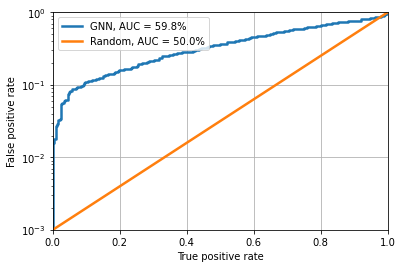

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.plot([0, 1], [0.001, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [25]:
import uproot
n_events=1000
raw_path = '/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root'
root_file = uproot.open(raw_path)

tree = root_file['deepntuplizer/tree']

feature_array = tree.arrays(branches=features,
                                        entrystop=n_events,
                                        namedecode='utf-8')

label_array_all = tree.arrays(branches=labels,
                                          entrystop=n_events,
                                          namedecode='utf-8')
            
n_samples = label_array_all[labels[0]].shape[0]

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#used in src/model/baseline_model.py, src/model/model.py, and src/analysis/compare.py
def visualize(name, test=False):
    
    if test:
        vis_path = 'test/'
    else:
        vis_path = 'data/visualizations/'
    
    plt.savefig(vis_path + name)
    
    return None

#used in src/model/baseline_model.py, src/model/model.py
def visualize_loss(model):
    
    plt.figure()
    plt.plot(model.history['loss'],label='Loss')
    plt.plot(model.history['val_loss'],label='Val. loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return None

#used in src/analysis/compare.py
def visualize_roc_compare(fpr, tpr):
    
    plt.figure()
    plt.plot(fpr, tpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
    plt.xlabel(r'False positive rate')
    plt.ylabel(r'True positive rate')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()
    
    return None

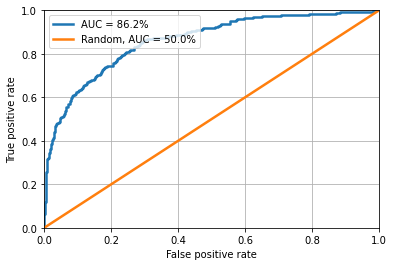

In [29]:
visualize_roc_compare(fpr_gnn, tpr_gnn)

In [31]:
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])

IndexError: index 2 is out of bounds for axis 1 with size 2

In [27]:
# COMPARING MODELS
predict_array_gnn = []
label_array_test = []

for t in test_dataset:
    label_array_test.append(t[:])
    predict_array_gnn.append(model.predict(t[0]))


predict_array_dnn = np.concatenate(predict_array_dnn,axis=0)
predict_array_cnn = np.concatenate(predict_array_cnn,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)

fpr_dnn = []
tpr_dnn = []
fpr_cnn = []
tpr_cnn = []
nlabels = 6

# create ROC curves for each class
for i in range(nlabels):
    t_fpr_d, t_tpr_d, thresh_d = roc_curve(label_array_test[:,i], predict_array_gnn[:,i])
        
    #appending
    fpr_dnn.append(t_fpr_d)
    tpr_dnn.append(t_tpr_d)
    fpr_cnn.append(t_fpr_c)
    tpr_cnn.append(t_tpr_c)

# plot ROC curves
visualize_roc(fpr_cnn, tpr_cnn, fpr_dnn, tpr_dnn, True)

AttributeError: 'InteractionNetwork' object has no attribute 'predict'

In [12]:
pip install e3nn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 89 kB 8.0 MB/s  eta 0:00:01
     |████████████████████████████████| 16.6 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.9 MB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 512 kB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 295 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 82.8 MB/s eta 0:00:01
     |████████████████████████████████| 246 kB 79.6 MB/s eta 0:00:01
     |████████████████████████████████| 578 kB 73.5 MB/s eta 0:00:01
  Created wheel for pymatgen: filename=pymatgen-2020.12.31-cp38-cp38-linux_x86_64.whl size=4182894 sha256=9bee9829d2e36cf830a24ec266383f62ec379a5ddb7d162f54d31307a6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
